In [1]:
import os
import subprocess
from IPython.display import FileLink, display
import gc
import random
import time

import matplotlib.pyplot as plt
import matplotlib as mpl

import pywt
from math import ceil
import scipy as sp
from scipy import signal
from scipy import fftpack

import json
from tqdm import tqdm
import glob
import re
from typing import Iterable
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
!pip install torcheval --no-index --find-links=file:///kaggle/input/torcheval/torcheval/
from torcheval.metrics import MulticlassAUPRC
from torcheval.metrics import BinaryAUPRC
#import pytorch_lightning as pl

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.cuda.amp import GradScaler

from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, average_precision_score

import warnings
warnings.filterwarnings(action='ignore')

Looking in links: file:///kaggle/input/torcheval/torcheval/
Processing /kaggle/input/torcheval/torcheval/torcheval-0.0.6-py3-none-any.whl
Processing /kaggle/input/torcheval/torcheval/torchtnt-0.1.0-py3-none-any.whl (from torcheval)
Processing /kaggle/input/torcheval/torcheval/pyre_extensions-0.0.30-py3-none-any.whl (from torchtnt>=0.0.5->torcheval)


In [2]:
class Config:
    datasets_folder = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/'
    step_data_folder = '/kaggle/input/step-data/features/'
    working_folder = '/kaggle/working/'
    tdcs_features_ds_folder = '/kaggle/input/tdcs-steps/kaggle/working/features/'
    data_names = ('tdcsfog', 'defog')
    #saved_features_file = '.csv'
    frequencies = (128, 100)
    g = 9.806

    batch_size = 1
    num_workers = 8
    
    feature_window_size = 128
    
    window_size = 512
    window_front = 96
    window_back = 96
    window_body = window_size - window_front - window_back
    #window_future = 8
    #window_past = window_size - window_future
    
    model_dropout = 0.1
    model_nlayers = 4
    model_middles = [16, 12, 8, 4]
    model_nblocks = 4
    model_layers_grow = 0
    
    #lr = 0.00015
    lr = 0.00002
    num_epochs_per_turn = 20
    num_turns = 3
    eval_freq = 5
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    feature_list = ['acc_v', 'acc_ml', 'acc_ap']
    nfeatures = len(feature_list)
    label_list_full = ['start_hesitation', 'turn', 'walking']
    label_list = label_list_full
    #label_list = ['walking']
    #label_list = ['start_hesitation']
    #label_list = ['start_hesitation', 'walking']
    nlabels = len(label_list)
    
    load_model_from_file = False
    model_file = '/kaggle/input/model-state-02/model_state_02.h5'
    
cfg = Config()
#cfg.lr = 0.00003
#cfg.model_dropout = 0.1
#cfg.num_epochs = 3

In [3]:
cfg.device

'cuda'

In [4]:
def make_layers( nl = cfg.model_nlayers, grow = cfg.model_layers_grow ):
    base = (cfg.window_front + cfg.window_back - grow * nl * (nl+1)//2)//nl
    layers_list = np.array([1 + base + (i+1)*grow for i in range(nl)])
    layers_list = layers_list + 1 - np.divmod(layers_list, 2)[1]
    layers_list[-1] = cfg.window_front + cfg.window_back + nl - sum(layers_list[0:-1])
    print('layers', layers_list)
    print('zero is correct', sum(layers_list)- nl - cfg.window_front - cfg.window_back)
    return layers_list
cfg.layers = make_layers()

layers [49 49 49 49]
zero is correct 0


In [5]:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

def read_data_file(test_id, subfolder_name = 'train/tdcsfog/'):
    try:
        data = pd.read_csv(cfg.datasets_folder+subfolder_name + str(test_id) + '.csv')
    except:
        return pd.NA
    data.columns = [camel_to_snake(c) for c in data.columns]
    return data

def _find_binary(items: Iterable[int], item: int):
    min = 0
    max = len(items)-1
    if items[max]<=item:
        return max
    while min<max:
        split = (max+min)//2
        item_split = items[split]
        if item < item_split:
            max = split
        else:
            min = split+1
    return min

In [6]:
def detect_steps(signal, frequency=128, smoothing=2, faster_please=False, min_scale_log=3.6, max_scale_log=5.4):
    
    # scales for wavelets that define frequencies, exp for more even distribution
    # choosing border values is tricky
    # too narrow and we lose some slow or fast steprates
    # too wide and we get the steprate wrong for unusual walking wavelet spectrum cases
    # check patient #6 in the tdcsfog dataset as an example of an unusual pattern
    scales = np.exp(np.arange(min_scale_log, max_scale_log, 0.05))
    wavelet='morl'  # chosing the Morlet wavelet
    
    # transforming the signal, preferrably the 'AccMl' one
    coeff, freq = pywt.cwt(signal, scales, wavelet)
    # finding the brightest dots on every time slice
    coeff_argmax_index = np.argmax(abs(coeff), 0)
    # and collecting their coeff values in a new "signal", which already looks like our step rate, but is a bit noisy
    coeff_max = np.array([coeff[coeff_argmax_index[i], i] for i in range(coeff.shape[1])])
    
    # repeating the smoothing procedure
    for i in range(smoothing):
        # transforming the noisy step rate again to clear it
        coeff, freq = pywt.cwt(coeff_max, scales, wavelet)
        # finding the brightest dots on every time slice
        coeff_argmax_index = np.argmax(abs(coeff), 0).astype(int)
        # and smoothing their indices with median to cut some outbursts off
        coeff_argmax_index = np.round(pd.Series(coeff_argmax_index).rolling(128, center=True, min_periods=1).median()).astype(int)
        # collecting the values along our line of indices
        coeff_max = np.array([coeff[coeff_argmax_index[i], i] for i in range(coeff.shape[1])])
    
    # this smoothing round is optional
    if not faster_please:
        # finding hopefully bigger peaks on our line
        # hopefully skiping too narrow or too close ones that are likely to be outbursts
        max_cwt_points = sp.signal.find_peaks(abs(coeff_max), distance=20, width=20)[0]
        max_cwt_points = np.concatenate(([0], max_cwt_points, [len(signal)-1]))
        # and interpolating our line in wavelet space between the bigger peaks
        max_cwt_line_indexes = np.round(np.interp( range(0, len(signal)), max_cwt_points, 
                                                    coeff_argmax_index[max_cwt_points])).astype(int)
        coeff_max = np.array([coeff[max_cwt_line_indexes[i], i] for i in range(coeff.shape[1])])
    
    # finding zeroes on this smooth line to separate individual steps from other steps    
    zero_crossings = np.where( np.diff(np.sign(pd.Series(coeff_max).rolling(10, center=True, min_periods=1).mean())))[0]
    zero_crossings = np.concatenate( ([0], zero_crossings, [len(signal)]))    
    #filling each step with its duration while cutting possible outbursts with median
    step_lengths = []
    for i in range(1, len(zero_crossings)):
        step_lengths = np.concatenate( (step_lengths, [zero_crossings[i] - zero_crossings[i-1]]*(zero_crossings[i] - zero_crossings[i-1]) ))
    step_durations = pd.Series(step_lengths).rolling(32, center=True, min_periods=1).median()
    # making a nice and smooth step_rate array
    step_rate = pd.Series( 1./step_durations )*frequency
    step_rate = step_rate.where(step_rate<5, 0).rolling(frequency, center=True, min_periods=1).mean()
    
    return step_rate, step_durations/frequency, zero_crossings

In [7]:
%%time
#folder_path_tdcs = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/'
# folder_path_defog = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/'
#all_files_tdcs = [file for file in os.listdir(folder_path_tdcs)]
# all_files_defog = [file for file in os.listdir(folder_path_defog)]

#df_tdcsfog = pd.DataFrame(all_files_tdcs, columns = ['id'])
#df_tdcsfog['id'] = df_tdcsfog['id'].apply(lambda x: x.rsplit('.',1)[0])
#df_tdcsfog['data'] = df_tdcsfog['id'].apply(read_data_file)

#df_tdcsfog['fog'] = df_tdcsfog['data'].apply(lambda x: x[['walking', 'start_hesitation']].max().max())
#train_ids, valid_ids = train_test_split(df_tdcsfog['id'], random_state=42, stratify = df_tdcsfog['fog'])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


In [8]:
#os.mkdir('/features/')
#os.mkdir('/features/zero_crossings/')

In [9]:
cfg.working_folder = '/kaggle/working/'
def make_feature_file(data_row):
    #data = data_row['data']
    step_rate, step_durations, zero_crossings = detect_steps(data_row['data']['acc_ml'])
    data_row['data']['step_rate'] = step_rate
    data_row['data']['step_durations'] = step_durations
    data_row['data'].to_csv(cfg.working_folder + 'features/'+data_row['id']+'.csv')
    pd.DataFrame(zero_crossings).to_csv(cfg.working_folder + 'features/zero_crossings/'+data_row['id']+'.csv')
    

#def make_feature_files(dataset):
#    for data_row in tqdm(dataset):
#        data = data_row['data']
#        step_rate, step_durations, zero_crossings = detect_steps(data['acc_ml'])
#        data_row['data']['steprate'] = step_rate
#        data_row['data']['step_durations'] = step_durations
#        data_row['data']['zero_crossings'] = zero_crossings
#        data_row['data'].to_csv('features/'+data_row['id']+'.csv')

In [10]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [11]:
def download_model(model_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{model_name}.zip"
    command = f"zip {zip_name} {model_name}"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{model_name}.zip'))

In [12]:
#download_file('/kaggle/working/features/', 'features.zip')
download_model('best_model_state_02.h5')
#download_file('/kaggle/working/features/', 'features.zip')

/kaggle/working/best_model_state_02.h5.zip

In [13]:
#%%time
#make_feature_files(df_tdcsfog)
#try:
#    os.mkdir(cfg.working_folder + 'features/')
#    os.mkdir(cfg.working_folder + 'features/zero_crossings/')
#except: 
#    pass

#df_tdcsfog.apply(make_feature_file, axis=1)

In [14]:
cfg.wavelet_scales = np.exp(np.arange(2, 6, 0.5))
cfg.wavelet_list = [ f'wave_{scale}' for scale in cfg.wavelet_scales ] 
cfg.wavelet='morl'
#wavelet='shan'

def make_features_train(data):
    mean_center = True
    rolling_window_size = cfg.feature_window_size
    data['acc_ml_abs_rolling_mean'] = abs(data['acc_ml']).rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['acc_ml_abs_rolling_min'] = abs(data['acc_ml']).rolling(rolling_window_size, center=mean_center, min_periods=1).min()
    data['acc_ml_abs_rolling_max'] = abs(data['acc_ml']).rolling(rolling_window_size, center=mean_center, min_periods=1).max()
    data['acc_apv'] = (data['acc_ap']**2 + data['acc_v']**2)**0.5 - 9.806
    data['acc_apv_rolling_mean'] = abs(data['acc_apv']).rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['acc_apv_rolling_delta'] = abs(data['acc_apv']).rolling(rolling_window_size, center=mean_center, min_periods=1).max() -\
        abs(data['acc_apv']).rolling(rolling_window_size, center=mean_center, min_periods=1).min()
    data['angle'] = data['acc_ap'] / data['acc_v'].rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['angle_rolling_mean'] = data['angle'].rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['acc_v'] = data['acc_v']/3
    
    coeff, freq = pywt.cwt(data['acc_ml'], cfg.wavelet_scales, cfg.wavelet)
    for i, scale in enumerate(cfg.wavelet_scales):
        data[f'wave_{scale}'] = coeff[i] 
    
    coeff_argmax = pd.Series(freq[np.argmax(abs(coeff), 0)]*cfg.frequencies[0])\
        .rolling(50, center=mean_center, min_periods=1).median().rolling(50, center=mean_center, min_periods=1).max()
    data['coeff_argmax'] = coeff_argmax
    
    return data


def make_features(data):
    data = make_features_train(data)
    
    step_rate, step_durations, zero_crossings = detect_steps(data['acc_ml'])
    data['steprate'] = step_rate
    data['step_durations'] = step_durations
    return data
    

def make_features_row(data_row, df_name):
    data = data_row['data']
    mean_center = True
    rolling_window_size = rolling_window_size = cfg.feature_window_size
    data['acc_ml_abs_rolling_mean'] = abs(data['acc_ml']).rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['acc_ml_abs_rolling_min'] = abs(data['acc_ml']).rolling(rolling_window_size, center=mean_center, min_periods=1).min()
    data['acc_ml_abs_rolling_max'] = abs(data['acc_ml']).rolling(rolling_window_size, center=mean_center, min_periods=1).max()
    #data['steprate'] = abs(data['acc_ml']).rolling(128, center=True, min_periods=1).max()
    data['acc_apv'] = (data['acc_ap']**2 + data['acc_v']**2)**0.5 - 9.806
    data['acc_apv_rolling_mean'] = abs(data['acc_apv']).rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['acc_apv_rolling_delta'] = abs(data['acc_apv']).rolling(rolling_window_size, center=mean_center, min_periods=1).max() -\
        abs(data['acc_apv']).rolling(rolling_window_size, center=mean_center, min_periods=1).min()
    data['angle'] = data['acc_ap'] / data['acc_v'].rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['angle_rolling_mean'] = data['angle'].rolling(rolling_window_size, center=mean_center, min_periods=1).mean()
    data['acc_v'] = data['acc_v']/3
    #data['acc_ap'] = data['acc_ap']
    tmp_df = pd.read_csv(cfg.tdcs_features_ds_folder + data_row['id'] + '.csv')
    data = data.join(tmp_df[['steprate', 'step_durations']])
    
    scales = np.exp(np.arange(2, 6, 0.5))
    wavelet='morl'
    #wavelet='shan'
    coeff, freq = pywt.cwt(data['acc_ml'], scales, wavelet)
    cfg.wavelet_list = []
    for i, scale in enumerate(scales):
        data[f'wave_{scales}'] = coeff[i]
        cfg.wavelet_list.append(f'wave_{scales}')
    coeff_argmax = pd.Series(freq[np.argmax(abs(coeff), 0)]*cfg.frequencies[0])\
        .rolling(50, center=mean_center, min_periods=1).median().rolling(50, center=mean_center, min_periods=1).max()
    data['coeff_argmax'] = coeff_argmax
    
    return data

In [15]:
%%time
#df_tdcsfog['data'] = df_tdcsfog.apply(make_features_row, axis=1)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.58 µs


In [16]:
cfg.feature_list = [
    #'acc_v',           doesn't help
    'acc_ml', 
    #'acc_ap',
    'acc_ml_abs_rolling_mean',
    'acc_ml_abs_rolling_min',
    'acc_ml_abs_rolling_max',
    'acc_apv',
    'acc_apv_rolling_mean',
    'acc_apv_rolling_delta',
    #'angle',
    'angle_rolling_mean',
    'step_rate',
 #   'step_durations', doesn't help - maybe they were just too big
 #   'coeff_argmax'    doesn't help
] + cfg.wavelet_list

cfg.nfeatures = len(cfg.feature_list)

In [17]:
class cDataHolder():
    def __init__(self):
        return
    
    def make_fog_class(self, row):
        if ( row['fog_walking'] == 0 ) and ( row['fog_start_hesitation'] == 0 ):
            fog_class = 'fog_no_complex'
        elif ( row['fog_walking'] == 0 ) and ( row['fog_start_hesitation'] < 2500 ):
            fog_class = 'fog_some_hesitation'
        elif ( row['fog_walking'] < 2500) and ( row['fog_start_hesitation'] == 0 ):
            fog_class = 'fog_some_walking'
        elif ( row['fog_walking'] >= 2500):
            fog_class = 'fog_bad_walking'
        elif ( row['fog_start_hesitation'] >= 2500 ):
            fog_class = 'fog_bad_hesitation'
        else:
            fog_class = 'fog_some_complex'
        return fog_class
    
    def prepare_data_row(self, data_id, ds_name):
        ds_name = ds_name + '/'
        file_df = pd.read_csv(cfg.datasets_folder + 'train/' + ds_name + data_id +'.csv')
        file_df.columns = [camel_to_snake(c) for c in file_df.columns]
        steps_df = pd.read_csv(cfg.step_data_folder + ds_name + data_id +'.csv')
        file_df = file_df.join(steps_df)
        # ----------------- rescale time here
        
        file_df = make_features_train(file_df)
        self.list_x.append(file_df[cfg.feature_list].values)
        self.list_y.append(file_df[cfg.label_list].values)
        return len(self.list_x)-1
    
    def load_train_data(self):
        folder_path_tdcs = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/'
        all_files_tdcs = [file for file in os.listdir(folder_path_tdcs)]
        self.df_tdcs = pd.DataFrame(all_files_tdcs, columns = ['id'])
        self.df_tdcs['id'] = self.df_tdcs['id'].apply(lambda x: x.rsplit('.',1)[0])
        
        self.list_x, self.list_y = [], []
        
        for index, row in tqdm(self.df_tdcs.iterrows()):
            #self.df_tdcs['main_index'][index] = 
            self.prepare_data_row(row['id'], 'tdcsfog')
        
        self.df_tdcs['tdcs'] = True
        self.df = self.df_tdcs.copy()
        
        folder_path_defog = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/'
        all_files_defog = [file for file in os.listdir(folder_path_tdcs)]
        self.df_defog = pd.DataFrame(all_files_defog, columns = ['id'])
        self.df_defog['id'] = self.df_defog['id'].apply(lambda x: x.rsplit('.',1)[0])
        
        for index, label in enumerate(cfg.label_list):
            dataholder.df['fog_'+label] = dataholder.df.reset_index()['index'].apply( lambda x: dataholder.list_y[x][:,index].sum())
            
        self.df['fog_class'] = self.df.apply(self.make_fog_class, axis=1)
            
        
    def prepare_train_valid(self, complex_mult=10):    
        self.train_nums, self.valid_nums = train_test_split(self.df.index, stratify = self.df['fog_class'])
        df_train = self.df.loc[self.train_nums]['fog_class']
        df_complex = df_train[df_train!='fog_no_complex']
        df_fog = df_train[df_train=='fog_no_complex']
        #print(len(df_fog), len(df_complex))
        for i in range(10):
            df_fog = df_fog.append(df_complex)            
        self.train_nums = df_fog.sample(frac=1).index
    
    def get_data(self, index, add_zeros = True):
        x = self.list_x[index]
        y = self.list_y[index]
        if add_zeros:
            x = np.concatenate(( np.zeros((cfg.window_front, x.shape[1])) , x, np.zeros((cfg.window_front, x.shape[1])) ))
            
        x = torch.tensor(x).to(torch.float32)
        y = torch.Tensor(np.argmax(y,axis=1)).to(torch.int64)
        return x, y
        
    def __getitem__(self, index, is_train, add_zeros = True):
        file_index = self.train_nums[index] if is_train else self.valid_nums[index]
        return self.get_data(file_index)
    
    def get_file_batch(self, file_index, add_zeros = True, want_valid = False):
        return  self.__getitem__(self, file_index, not want_valid, add_zeros)
    
    def get_file_batch_id(self, file_id, add_zeros = True):
        file_index = self.df[ self.df['id']==file_id ].index[0]
        return self.get_data(file_index)
    
    def make_file_batch(self, file_data, add_zeros = True, with_targets=False):
        x = file_data[cfg.feature_list].values
        if add_zeros:
            x = np.concatenate(( np.zeros((cfg.window_front, x.shape[1])) , x, np.zeros((cfg.window_front, x.shape[1])) ))
        x = torch.tensor(x).to(torch.float32).view(1, -1, cfg.nfeatures)
        return x
    
dataholder = cDataHolder()

In [18]:
def __getitem__(holder, index, is_train, add_zeros = True):
    file_index = dataholder.train_nums[index] if is_train else dataholder.valid_nums[index]
    return dataholder.get_data(file_index)

In [19]:
dataholder.load_train_data()

833it [00:58, 14.36it/s]


In [20]:
#df_simple = self.df[self.df['fog_class']=='fog_no_complex']
df_complex = dataholder.df[dataholder.df['fog_class']!='fog_no_complex']['fog_class']
df_fog = dataholder.df[dataholder.df['fog_class']=='fog_no_complex']['fog_class']
print(len(df_fog), len(df_complex))
for i in range(10):
    df_fog = df_fog.append(df_complex)

df_fog.value_counts()

706 127


fog_no_complex         706
fog_some_hesitation    470
fog_some_walking       330
fog_some_complex       190
fog_bad_hesitation     150
fog_bad_walking        130
Name: fog_class, dtype: int64

In [21]:
df_fog.sort_index()

0      fog_no_complex
1      fog_no_complex
2      fog_no_complex
3      fog_no_complex
4      fog_no_complex
            ...      
828    fog_no_complex
829    fog_no_complex
830    fog_no_complex
831    fog_no_complex
832    fog_no_complex
Name: fog_class, Length: 1976, dtype: object

In [56]:
dataholder.prepare_train_valid()

In [24]:
#for index, row in tqdm(dataholder.df.iterrows()):
#            row['fog'] = dataholder.list_y[cfg.label_list.index('walking')].sum()
#label_list[1]
for index, label in enumerate(cfg.label_list):
    dataholder.df['fog_'+label] = dataholder.df.reset_index()['index'].apply( lambda x: dataholder.list_y[x][:,index].sum())
#dataholder.df['walking_fog'] = dataholder.df.reset_index()['index'].apply( lambda x: dataholder.list_y[x][:,cfg.label_list.index('turn')].sum())
dataholder.df.sum()

id                      a171e618404171ea3a0c0f985a84405d320ade20ae8c67...
tdcs                                                                  833
fog_start_hesitation                                               304790
fog_turn                                                          1678782
fog_walking                                                        207838
fog_class               fog_no_complexfog_no_complexfog_no_complexfog_...
dtype: object

<Axes: >

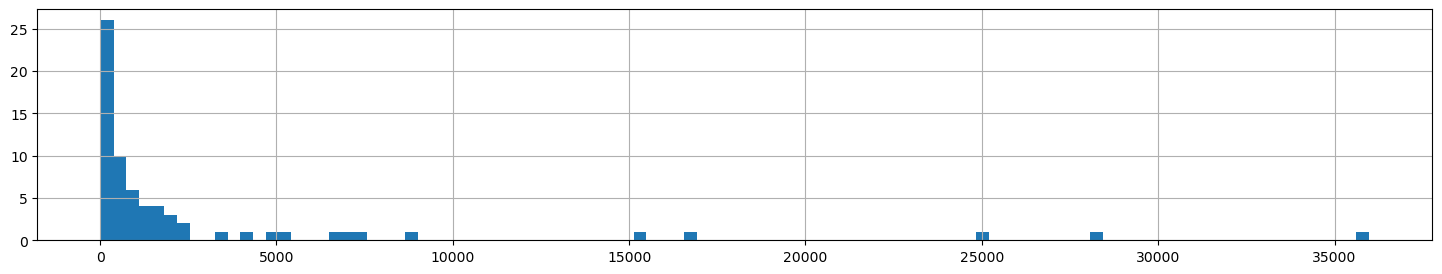

In [25]:
dataholder.df['fog_walking'][dataholder.df['fog_walking']>0].hist(bins=100, figsize=(18,3))

In [26]:
def make_fog_class(row):
    if ( row['fog_walking'] == 0 ) and ( row['fog_start_hesitation'] == 0 ):
        fog_class = 'fog_no_complex'
    elif ( row['fog_walking'] == 0 ) and ( row['fog_start_hesitation'] < 2500 ):
        fog_class = 'fog_some_hesitation'
    elif ( row['fog_walking'] < 2500) and ( row['fog_start_hesitation'] == 0 ):
        fog_class = 'fog_some_walking'
    elif ( row['fog_walking'] >= 2500):
        fog_class = 'fog_bad_walking'
    elif ( row['fog_start_hesitation'] >= 2500 ):
        fog_class = 'fog_bad_hesitation'
    else:
        fog_class = 'fog_some_complex'
    return fog_class

In [27]:
dataholder.df['fog_class'] = dataholder.df.apply(make_fog_class, axis=1)
dataholder.df['fog_class'].value_counts()

fog_no_complex         706
fog_some_hesitation     47
fog_some_walking        33
fog_some_complex        19
fog_bad_hesitation      15
fog_bad_walking         13
Name: fog_class, dtype: int64

In [28]:
dataholder.df['fog_start_hesitation'][dataholder.df['fog_start_hesitation']>100].count()

87

In [29]:
%%time
#dataholder.load_train_data()

833it [00:45, 18.15it/s]


CPU times: user 43.8 s, sys: 499 ms, total: 44.3 s
Wall time: 46 s


In [30]:
class cFOGDataset_for_dataholder(Dataset):
    def __init__(self, is_train=True, split="train"):
        self.is_train = is_train
        self.split = split
        return
    def __len__(self):
        return len(dataholder.train_nums) if self.is_train else len(dataholder.valid_nums)
    def __getitem__(self, index, add_zeros = True):
        return( dataholder.__getitem__(index, self.is_train, add_zeros) )
    
ds_train = cFOGDataset_for_dataholder(is_train=True, split = 'train')
ds_valid = cFOGDataset_for_dataholder(is_train=False, split = 'valid')

In [31]:
class cFOGDataset_06(Dataset):
    def __init__(self, init_data, is_train=True, split="train"):
        self.df = init_data.loc[:, init_data.columns != 'data']
        self.df['t_count'] = init_data['data'].apply(lambda x: x['time'].count())
        self.df['window_count'] = np.ceil(self.df['t_count'] / cfg.window_body ).astype(int)
        self.df['window_sum'] = self.df['window_count'].cumsum()
        self.df['window_extra'] = self.df['window_count']*cfg.window_body - self.df['t_count']
        self.is_train = is_train
        self.split = split
        self.list_x, self.list_y = [], []
        for i in range(len(init_data)):
            self.list_x.append(init_data.loc[i, 'data'][cfg.feature_list].values)
            if is_train:
                targets = init_data.loc[i, 'data'][cfg.label_list].values
                self.list_y.append( np.concatenate([targets, (1 - targets.sum(axis=1)).reshape(-1,1)], axis=1) )  
        
    def __len__from_05(self):
        return self.df['window_count'].sum()
    
    def __len__(self):
        return self.df['window_count'].count()
    
    def get_index_y(self, index):
        file_index = _find_binary(self.df['window_sum'], index)
        infile_index = index if file_index==0 else index - self.df['window_sum'][file_index-1]
        time_index = infile_index * cfg.window_body
        return file_index, infile_index, time_index
    
    def get_file_batch(self, file_index, add_zeros = True):
        x = self.list_x[file_index]
        y = self.list_y[file_index]
        if add_zeros:
            x = np.concatenate(( np.zeros((cfg.window_front, x.shape[1])) , x, np.zeros((cfg.window_front, x.shape[1])) ))
        x = torch.tensor(x).to(torch.float32).view(1, -1, cfg.nfeatures)
        y = torch.Tensor(np.argmax(y,axis=1)).to(torch.int64).view(1, -1)
        return x, y, self.df.loc[file_index, 'id']
    
    def get_file_batch_id(self, file_id, add_zeros = True):
        file_index = self.df[ self.df['id']==file_id ].index[0]
        x = self.list_x[file_index]
        y = self.list_y[file_index]
        if add_zeros:
            x = np.concatenate(( np.zeros((cfg.window_front, x.shape[1])) , x, np.zeros((cfg.window_front, x.shape[1])) ))
        x = torch.tensor(x).to(torch.float32).view(1, -1, cfg.nfeatures)
        y = torch.Tensor(np.argmax(y,axis=1)).to(torch.int64).view(1, -1)
        return x, y
    
    def make_file_batch(self, file_data, add_zeros = True, with_targets=False):
        x = file_data[cfg.feature_list].values
        if add_zeros:
            x = np.concatenate(( np.zeros((cfg.window_front, x.shape[1])) , x, np.zeros((cfg.window_front, x.shape[1])) ))
        x = torch.tensor(x).to(torch.float32).view(1, -1, cfg.nfeatures)
        return x
    
    def __getitem__(self, index, verbose = False, add_zeros = True):
        x = self.list_x[index]
        y = self.list_y[index]
        if add_zeros:
            x = np.concatenate(( np.zeros((cfg.window_front, x.shape[1])) , x, np.zeros((cfg.window_front, x.shape[1])) ))
        x = torch.tensor(x).to(torch.float32)#.view(1, -1, cfg.nfeatures)
        y = torch.Tensor(np.argmax(y,axis=1)).to(torch.int64)#.view(-1, 1)
        return x, y
    
    def __getitem__from_05(self, index, verbose = False, add_zeros = True):
        file_index = _find_binary(self.df['window_sum'], index)
        infile_index = index if file_index==0 else index - self.df['window_sum'][file_index-1]
        #time_index = infile_index * cfg.window_body - cfg.window_front
        time_index = infile_index * cfg.window_body
        x_index = time_index - cfg.window_front
        front_zeros = 0
        if x_index < 0:
            front_zeros = -x_index
            x_index = 0
        
        x = self.list_x[file_index][ x_index : x_index + cfg.window_size - front_zeros ]
        y = self.list_y[file_index][ time_index : time_index + cfg.window_body ]
        
        rear_zeros = cfg.window_size - x.shape[0] - front_zeros
        
        if front_zeros or rear_zeros:
            if add_zeros and front_zeros:
                x = np.concatenate((np.zeros((front_zeros, x.shape[1])), x))
            if add_zeros and rear_zeros:
                x = np.concatenate((x, np.zeros((rear_zeros, x.shape[1]))))
                if rear_zeros > cfg.window_back:
                    y = np.concatenate((y, np.zeros((rear_zeros-cfg.window_back, y.shape[1]))))
                    
        if verbose:
            print('file_index =', file_index)
            print('window_count =', self.df.loc[file_index, 'window_count'])
            print('window_sum =', self.df.loc[file_index, 'window_sum'])
            if file_index>0:
                print('window-1_sum =', self.df.loc[file_index-1, 'window_sum'])
            print('t_count =', self.df.loc[file_index, 't_count'])
            print('window_extra =', self.df.loc[file_index, 'window_extra'])
            print('infile_index =', infile_index)
            print('time_index =', time_index)  
            print('x_index =', x_index)  
            print('front_zeros =', front_zeros)
            print('rear_zeros =', rear_zeros)
            
        x = torch.tensor(x).to(torch.float32)
        y = torch.Tensor(np.argmax(y,axis=1)).to(torch.int64)
        return x, y
    
#ds_train = cFOGDataset_06(df_tdcsfog.loc[train_ids.index].reset_index(drop=True), split = 'train')
#ds_valid = cFOGDataset_06(df_tdcsfog.loc[valid_ids.index].reset_index(drop=True), split = 'valid')
#ds_full = cFOGDataset_06(df_tdcsfog, split = 'train')

In [32]:
#def make_a_batch(ds, index=0, batch_size = 8):
#    xbatch = np.zeros((batch_size, cfg.window_size, cfg.nfeatures))
#    ybatch = np.zeros((batch_size, cfg.window_body))
#    for i in range(batch_size):
#        item_x, item_y = ds.__getitem__(index+i)
#        xbatch[i], ybatch[i] = item_x, item_y
#    
#    xbatch = torch.tensor(xbatch.astype(np.float32))
#    ybatch = torch.tensor(ybatch).to(torch.int64)
#    return xbatch, ybatch

#def make_a_batch_05(ds, index=0, batch_size = 8):
#    xbatch = np.zeros((batch_size, cfg.window_size, cfg.nfeatures))
#    ybatch = np.zeros((batch_size, cfg.window_body))
#    for i in range(batch_size):
#        item_x, item_y = ds.__getitem__(index+i)
#        xbatch[i], ybatch[i] = item_x, item_y
#    
#    xbatch = torch.tensor(xbatch.astype(np.float32))
#    ybatch = torch.tensor(ybatch).to(torch.int64)
#    return xbatch, ybatch

In [33]:
#x01,y01gt = make_a_batch(ds_train,0)

In [34]:
dropout = nn.Dropout(cfg.model_dropout)
conv1 = nn.Conv1d(cfg.nfeatures, 16, cfg.layers[0])
conv2 = nn.Conv1d(16, 16, cfg.layers[1])
conv3 = nn.Conv1d(16, 16, cfg.layers[2])
conv4 = nn.Conv1d(16, 16, cfg.layers[3])
linear = nn.Linear(16, cfg.nlabels+1)
relu = nn.ReLU()
softmax = nn.Softmax(dim=1)

In [35]:
#file0 = ds_train.get_file_batch(0)
#file0[1].shape
#x = file0[0]
#with torch.no_grad():
#    y = model1.forward(x)


In [36]:
#x = x01
#x = x.to(torch.float)
#print(x.shape)
#x = x.transpose(1,2)
#print(x.shape)
#x = conv1(x)
#print(x.shape)
#x = conv2(x)
#print(x.shape)
#x = conv3(x)
#print(x.shape)
#x = conv4(x)
#print(x.shape)
#x = x.transpose(1,2)
#print(x.shape)
#x = x.view(-1,16)
#print(x.shape)
#x = linear(x)
#print(x.shape)
#x = softmax(x)
#print(x.shape)
#print(x[0])

In [37]:
class FOGModel(nn.Module):
    def __init__(self, p=cfg.model_dropout, nblocks=cfg.model_nblocks, layers_list = cfg.layers):
        super(FOGModel, self).__init__()
        self.dropout = nn.Dropout(p)
        self.mid = cfg.model_middles
        self.nlabels = cfg.nlabels
        self.conv1 = nn.Conv1d(cfg.nfeatures, self.mid[0], layers_list[0])
        self.conv2 = nn.Conv1d(self.mid[0], self.mid[1], layers_list[1])
        self.conv3 = nn.Conv1d(self.mid[1], self.mid[2], layers_list[2])
        self.conv4 = nn.Conv1d(self.mid[2], self.mid[3], layers_list[3])
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(self.mid[3], cfg.nlabels+1)
        #self.linear2 = nn.Linear(self.mid[3], cfg.nlabels+1)
        #self.softmax = nn.Softmax(dim=2)
        #self.softmax = F.log_softmax(dim=2)

        self.dropout = nn.Dropout(cfg.model_dropout)

        
        
    def forward(self, x):
        x = x.transpose(1,2)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = x.transpose(1,2)
        x = self.linear1(x)
        #x = self.relu(x)
        
        #x = self.linear2(x) 
        x = F.log_softmax(x, dim=2)
        return x#[:,:,:-1]

In [38]:
class ConvBlock_01(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dropout_rate):
        super(ConvBlock_01, self).__init__()

        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.batch_norm = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)
        self.skip_offset = kernel_size//2

        self.skip_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1) \
            if in_channels != out_channels else nn.Identity()
        self.identity = nn.Identity()

    def forward(self, x):
        #x = x.transpose(1, 2)
        skip = self.skip_connection(x)
        #skip = self.identity(x)

        x = self.conv(x)
        #print('x:',x.shape, 'skip:', skip.shape, 'skip fixed:', skip[:,:,self.skip_offset:self.skip_offset+x.shape[2]].shape)
        #skip = skip[:,:,self.skip_offset:self.skip_offset+x.shape[2]]
        #print('x:',x.shape, 'skip:', skip.shape, 'skip fixed:', skip[:,:,self.skip_offset:self.skip_offset+x.shape[2]].shape)
        #print('skip offset', self.skip_offset)     
        x = self.batch_norm(x + skip[:,:,self.skip_offset:self.skip_offset+x.shape[2]])
        x = F.relu(x)
        x = self.dropout(x)
        #x = x.transpose(1, 2)

        return x
    
class FOGModel_02(nn.Module):
    def __init__(self, dropout_rate=cfg.model_dropout, in_channels=cfg.nfeatures, nblocks=cfg.model_nblocks, layers_list = cfg.layers):
        super(FOGModel_02, self).__init__()
        #self.dropout = nn.Dropout(p)
        self.dropout_rate = dropout_rate
        self.nblocks = cfg.model_nblocks
        self.nlabels = cfg.nlabels
        self.in_channels = in_channels
        self.out_channels = cfg.nlabels
        self.mid = cfg.model_middles
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.mid[3], self.out_channels+1)
        #self.softmax = nn.Softmax(dim=2)
        
        self.blocks = nn.Sequential(*[
            ConvBlock_01(in_channels if i == 0 else self.mid[i-1], 
                      self.mid[i], 
                      layers_list[i], 
                      self.dropout_rate)
            for i in range(nblocks)
        ])       
        
    def forward(self, x):
        x = x.transpose(1,2)
        x = self.blocks(x)
        x = x.transpose(1,2)
        x = self.linear(x)
        x = F.log_softmax(x) 
        return x#[:,:,:-1]

In [39]:
#model2 = FOGModel_02()
#model1 = FOGModel()

In [40]:
#train_loader = DataLoader(ds_train, batch_size=cfg.batch_size, num_workers=cfg.num_workers, shuffle=True)
#for batch in train_loader:
#    xb, yb = batch
#    break

In [41]:
#y1 = model2.forward(xb)

In [42]:
def train_one_epoch(model, loader, optimizer, criterion):
    loss_sum = 0.
    scaler = GradScaler()
    
    model.train()
    #for x,y in loader:        
    for x,y in tqdm(loader):        
        x = x.to(cfg.device)
        y = y.to(cfg.device)

       
        y_pred = model(x)
        loss = criterion(y_pred.view(-1, y_pred.size(-1)), y.view(-1))           
        
        # loss.backward()
        scaler.scale(loss).backward()
        # optimizer.step()
        scaler.step(optimizer)
        scaler.update()       
        optimizer.zero_grad()  
        
        loss_sum += loss.item()
    
    print(f"Train Loss: {(loss_sum/len(loader)):.04f}")
    return loss_sum/len(loader)

In [43]:
def validation_one_epoch(model, loader, criterion, metric):
    loss_sum = 0.
    y_true_epoch = torch.empty((0), dtype=torch.int64).to(cfg.device)
    y_pred_epoch = torch.empty((0,cfg.nlabels), dtype=torch.float32).to(cfg.device)
    #t_valid_epoch = []
    
    model.eval()
    #for x,y in tqdm(loader):
    for x,y in loader:
        x = x.to(cfg.device)
        y = y.to(cfg.device)
        
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred.view(-1, y_pred.size(-1)), y.view(-1))
        
        loss_sum += loss.item()
        
        #print('cat', y_true_epoch.shape, y.view(-1, 1).shape)
        y_true_epoch = torch.cat([y_true_epoch, y.view(-1, 1)])
        #print('cat -----> y_pred_epoch:', y_pred_epoch.exp().shape, 'cat -----> y_pred:', y_pred.shape, 
        #      'cat -----> y_pred.view(-1, y_pred.size(-1)):', y_pred.view(-1, y_pred.size(-1)).shape)
        y_pred = y_pred[:,:,:-1]
        y_pred_epoch = torch.cat([y_pred_epoch, y_pred.view(-1, y_pred.size(-1))])
    
    #metric.update(y_pred_epoch, y_true_epoch.view(-1))
    y_pred_2 = y_pred_epoch
    
    #average_precision_score()
    #print('metric', y_pred_epoch.exp().shape, y_true_epoch.view(-1).shape)
    if model.nlabels > 1:
        metric.update(y_pred_epoch.exp(), y_true_epoch.view(-1))
    else:
        metric.update(y_pred_epoch.exp().view(-1), y_true_epoch.view(-1))
    scores = metric.compute()
    mean_score = scores.mean().cpu().numpy().item()
    #print(scores)
    #print(mean_score)
    
    #mask = torch.ones((1,cfg.nlabels), dtype=torch.float32).to(cfg.device)
    #mask[0,cfg.nlabels-1] = 0
    #metric.update(y_pred_epoch.exp()*mask, y_true_epoch.view(-1))
    #score2 = metric.compute().mean()
    
    if model.nlabels == 3:
        print(f"Validation Loss: {(loss_sum/len(loader)):.04f}, Validation Score: {mean_score:.03f}, ClassWise: {scores[0]:.03f},{scores[1]:.03f},{scores[2]:.03f}")    
    elif model.nlabels == 2:
        print(f"Validation Loss: {(loss_sum/len(loader)):.04f}, Validation Score: {mean_score:.03f}, ClassWise: {scores[0]:.03f},{scores[1]:.03f}")    
    else:
        print(f"Validation Loss: {(loss_sum/len(loader)):.04f}, Validation Score: {mean_score:.03f}")        
    return mean_score, (loss_sum/len(loader))

In [44]:
def predict_file(model, file_data):   
    model.eval()
    x = dataholder.make_file_batch(file_data).to(cfg.device)
    with torch.no_grad():
        y = model.forward(x)
    y = np.exp(y.cpu().numpy())
    return y

In [45]:
def plot_validation_graph(index, model, want_valid = True, file_id=None):
    if file_id==None:
        x, y_true = dataholder.get_file_batch(index, want_valid=want_valid)
    else:
        x, y_true = dataholder.get_file_batch_id(file_id)
    #get_file_batch(self, file_index, add_zeros = True, want_valid = False):
    model.eval()
    x = x.to(cfg.device)
    with torch.no_grad():
        y_pred = model.forward(x[None, :])
    y_pred = np.exp(y_pred.cpu().numpy())
    x = x.cpu().numpy()
    
    #tmpdf = pd.DataFrame(x, cfg.feature_list)
    #tmpdf = df_tdcsfog[ df_tdcsfog['id']==file_id ]['data'].iloc[0]
    result = pd.DataFrame( y_pred.reshape(-1, cfg.nlabels+1)[:,:cfg.nlabels], columns = cfg.label_list )
    
    figs, ax = plt.subplots(2,1, figsize=(18,5))
    #tmpdf[['acc_v','acc_ml','acc_ap']].plot(ax=ax[0])
    y_true_3 = np.zeros((y_true.shape[0], 4))
    y_true_3[:,3 - y_true.numpy()] = 1
    pd.DataFrame( y_true_3[:,:3], columns = [cfg.label_list] ).plot(ax=ax[0])
    result.reset_index(drop=True).plot(ax=ax[1])

In [46]:
#y_true.numpy()
#y_true_3 = np.zeros((y_true.shape[0], 4))
#y_true_3[:,3 - y_true.numpy()] = 1
#y_true_3

NameError: name 'y_true' is not defined

In [ ]:
y_true = np.array([3, 3, 3, 2, 1, 3, 0, 3])
y_true_3 = np.zeros((y_true.shape[0], 4))
y_true_3
np.put_along_axis(y_true_3, y_true[:,None], 1, axis=1)
y_true_3

In [ ]:
#p = zip(1,q)
q.shape

In [ ]:
q = (3 - y_true.numpy()).astype(int)
y_true_3 = np.zeros((y_true.shape[0], 4))
#y_true_3[: q] = 1
np.put_along_axis(y_true_3, q[:,None], 1, axis=0)
y_true_3.

In [ ]:
q = (3 - y_true.numpy()).astype(int)
y_true_3 = np.zeros((y_true.shape[0], 4))
#y_true_3[: q] = 1
y_true_3[np.arange(y_true_3.shape[1]) <= q[:, None]] = 0
y_true_3

In [ ]:
len(y_true_3 )

In [ ]:
plot_validation_graph(3, model)
#x, y_true = dataholder.get_file_batch(3, want_valid=True)
#x.shape
#y_true.shape[0]

In [ ]:
model.eval()
x = x.to(cfg.device)
with torch.no_grad():
    y_pred = model.forward(x[None, :])

In [ ]:
#validation_one_epoch(model, valid_loader, criterion, metric)

In [ ]:
#optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
#weights = torch.tensor([0.5, 0.5, 0.5, 0.1])
#criterion = torch.nn.CrossEntropyLoss().to(cfg.device)
#metric = MulticlassAUPRC( num_classes=cfg.nlabels, average=None )
#train_one_epoch(model, train_loader, optimizer, criterion)

In [ ]:
#cfg.lr = 0.00003
#cfg.model_dropout = 0.1
#cfg.num_epochs = 3

In [47]:
def train_model(model, optimizer, ds_train, ds_valid, num_epochs = cfg.num_epochs_per_turn, eval_freq = 1):
    #model = FOGModel_02().to(cfg.device)
    #model = FOGModel().to(cfg.device)
    #print(f"Number of parameters in model - {count_parameters(model):,}")

    #print(f"lengths of datasets: train - {len(train_dataset)}, valid - {len(valid_dataset)}")

    train_loader = DataLoader(ds_train, batch_size=cfg.batch_size, num_workers=cfg.num_workers, shuffle=True)
    valid_loader = DataLoader(ds_valid, batch_size=cfg.batch_size, num_workers=cfg.num_workers)

    #weights = torch.tensor([0.2, 0.3, 0.1, 0.5])
    #criterion = torch.nn.CrossEntropyLoss(weight=weights, reduction='none').to(cfg.device)
    #criterion = torch.nn.CrossEntropyLoss().to(cfg.device)
    criterion = torch.nn.NLLLoss().to(cfg.device)
    if cfg.nlabels > 1:
        metric = MulticlassAUPRC( num_classes=cfg.nlabels, average=None )
    else:
        metric = BinaryAUPRC()
    # sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)

    max_score, score = 0.0, 0.0

    print("="*50)
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch}")
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)

        if (epoch % eval_freq == eval_freq-1) and ( eval_freq != -1):
            score, val_loss = validation_one_epoch(model, valid_loader, criterion, metric)
            train_log.append([ train_loss, val_loss, score])
            #pd.DataFrame(train_log, columns=('Epoch', 'Train loss', 'Val loss', 'Val score')).plot()
            print("="*50)
        # sched.step()

        if score > max_score:
            max_score = score
            #torch.save(model.state_dict(), "best_model_state.h5")
            #print("Saving Model ...")
        

    torch.cuda.empty_cache()
    gc.collect()
    return model, optimizer

In [48]:
#torch.save(model.state_dict(), "best_model_state_01.h5")

In [49]:
#model = FOGModel().to(cfg.device)

In [50]:
cfg.lr

2e-05

In [57]:
if not cfg.load_model_from_file:
    #model = FOGModel_02().to(cfg.device)
    model = FOGModel().to(cfg.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

In [52]:
%%time
#model, optimizer = train_model(model, optimizer, ds_train, ds_valid, num_epochs = 1)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.78 µs


In [ ]:
%%time
#num_epochs_per_turn = 20
#num_turns = 5
#eval_freq = 5
train_log = []

if not cfg.load_model_from_file:
    for i in range(cfg.num_turns):
        print('Big epoch', i)
        model, optimizer = train_model(model, optimizer, ds_train, ds_valid, eval_freq = cfg.eval_freq, num_epochs = cfg.num_epochs_per_turn)
        #model, optimizer = train_model(model, optimizer, ds_full, ds_valid, eval_freq = cfg.eval_freq, num_epochs = cfg.num_epochs_per_turn)        
        
pd.DataFrame(train_log, columns=('Train loss', 'Val loss', 'Val score')).plot()

Big epoch 0
Epoch: 0


100%|██████████| 1479/1479 [00:23<00:00, 63.06it/s] 


Train Loss: 1.2548
Epoch: 1


100%|██████████| 1479/1479 [00:14<00:00, 101.20it/s]


Train Loss: 1.0182
Epoch: 2


100%|██████████| 1479/1479 [00:15<00:00, 97.05it/s] 


Train Loss: 0.9216
Epoch: 3


100%|██████████| 1479/1479 [00:14<00:00, 100.35it/s]


Train Loss: 0.8451
Epoch: 4


100%|██████████| 1479/1479 [00:15<00:00, 97.12it/s] 

Train Loss: 0.7796


Validation Loss: 0.4316, Validation Score: 0.609, ClassWise: 0.971,0.727,0.128
Epoch: 5


100%|██████████| 1479/1479 [00:14<00:00, 99.26it/s] 


Train Loss: 0.7173
Epoch: 6


100%|██████████| 1479/1479 [00:15<00:00, 97.61it/s] 


Train Loss: 0.6618
Epoch: 7


100%|██████████| 1479/1479 [00:14<00:00, 100.76it/s]


Train Loss: 0.6140
Epoch: 8


100%|██████████| 1479/1479 [00:15<00:00, 97.28it/s] 


Train Loss: 0.5751
Epoch: 9


100%|██████████| 1479/1479 [00:14<00:00, 100.65it/s]

Train Loss: 0.5484


Validation Loss: 0.3014, Validation Score: 0.591, ClassWise: 0.974,0.704,0.094
Epoch: 10


100%|██████████| 1479/1479 [00:15<00:00, 95.13it/s] 


Train Loss: 0.5305
Epoch: 11


100%|██████████| 1479/1479 [00:15<00:00, 98.00it/s] 


Train Loss: 0.5191
Epoch: 12


100%|██████████| 1479/1479 [00:15<00:00, 97.29it/s] 


Train Loss: 0.5110
Epoch: 13


100%|██████████| 1479/1479 [00:14<00:00, 99.56it/s] 


Train Loss: 0.5047
Epoch: 14


100%|██████████| 1479/1479 [00:15<00:00, 97.32it/s] 

Train Loss: 0.4982


Validation Loss: 0.2802, Validation Score: 0.590, ClassWise: 0.975,0.711,0.085
Epoch: 15


100%|██████████| 1479/1479 [00:14<00:00, 101.04it/s]


Train Loss: 0.4926
Epoch: 16


100%|██████████| 1479/1479 [00:15<00:00, 97.91it/s] 


Train Loss: 0.4900
Epoch: 17


100%|██████████| 1479/1479 [00:14<00:00, 99.22it/s] 


Train Loss: 0.4855
Epoch: 18


100%|██████████| 1479/1479 [00:15<00:00, 96.74it/s] 


Train Loss: 0.4826
Epoch: 19


100%|██████████| 1479/1479 [00:14<00:00, 100.11it/s]

Train Loss: 0.4794


Validation Loss: 0.2641, Validation Score: 0.591, ClassWise: 0.974,0.716,0.082
Big epoch 1
Epoch: 0


100%|██████████| 1479/1479 [00:15<00:00, 95.64it/s] 


Train Loss: 0.4764
Epoch: 1


100%|██████████| 1479/1479 [00:14<00:00, 100.17it/s]


Train Loss: 0.4749
Epoch: 2


100%|██████████| 1479/1479 [00:15<00:00, 96.10it/s] 


Train Loss: 0.4726
Epoch: 3


100%|██████████| 1479/1479 [00:14<00:00, 100.77it/s]


Train Loss: 0.4713
Epoch: 4


100%|██████████| 1479/1479 [00:15<00:00, 96.99it/s] 

Train Loss: 0.4674


Validation Loss: 0.3124, Validation Score: 0.629, ClassWise: 0.977,0.729,0.180
Epoch: 5


100%|██████████| 1479/1479 [00:14<00:00, 99.98it/s] 


Train Loss: 0.4667
Epoch: 6


 38%|███▊      | 562/1479 [00:05<00:08, 103.02it/s]

In [54]:
#model.load_state_dict(torch.load("best_model_state.h5", map_location=torch.device(cfg.device)))

In [55]:
train_log[4]

IndexError: list index out of range

In [ ]:
#np.array(train_log)
#.to('cpu').numpy()
#for log in train_log:
#    log[3] = log[3].cpu().numpy()

In [ ]:
#pd.DataFrame(train_log).plot(x='Epoch')

In [ ]:
if cfg.load_model_from_file:
    model = FOGModel()
    model.load_state_dict(torch.load(cfg.model_file, map_location=torch.device(cfg.device)))
    model.to(cfg.device)
    model.eval()

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/sample_submission.csv")

In [ ]:
test_folder_path = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog/'
test_files = [file for file in os.listdir(test_folder_path)]

In [ ]:
result = pd.DataFrame()
for test_file in test_files:
    test_df = pd.read_csv(test_folder_path + test_file) 
    test_df.columns = [camel_to_snake(c) for c in test_df.columns]
    test_df = make_features(test_df)
    #df_tdcsfog['id'] = df_tdcsfog['id'].apply(lambda x: x.rsplit('.',1)[0])
    test_file_id = test_file.rsplit('.',1)[0]
    pred = predict_file(model, test_df).reshape(-1,cfg.nlabels+1)
    #pred = np
    id_time = [f'{test_file_id}_{t}' for t in test_df['time']]
    tmp = pd.DataFrame(pred[:,:cfg.nlabels], index=id_time)#.loc[[t != -1 for t in time]]
    result = pd.concat([result, tmp])
        
result.columns = ['StartHesitation', 'Turn', 'Walking'][:cfg.nlabels]

sample_submission = sample_submission.set_index('Id')
sample_submission.update(result)
sample_submission.reset_index().to_csv('submission.csv', index=False)

In [ ]:
plot_validation_graph(2, ds_valid, model)
print()

In [ ]:
tmpdf = plot_validation_graph(3, model)

In [ ]:
tmpdf = plot_validation_graph(11, ds_valid, model)

In [ ]:
indices = df_tdcsfog[df_tdcsfog['fog']>0].index
ugly_ids = valid_ids[ valid_ids.index.isin(indices)]
ugly_ids.iloc[0]

In [ ]:
tmpdf = plot_validation_graph(11, ds_valid, model, file_id=ugly_ids.iloc[17])

In [ ]:
#os.listdir('/kaggle/working/')
#os.listdir('/features')

In [ ]:
figs, ax = plt.subplots(2,1, figsize=(18,5))
test_df[['acc_v','acc_ml','acc_ap']].plot(ax=ax[0])
result.reset_index(drop=True).plot(ax=ax[1])

In [ ]:
#x_slice = x[:, cfg.window_front:cfg.window_front+cfg.window_body ,:]
#x_slice.shape